# Data 

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns 

import tqdm

## Load Data

In [2]:
x = np.load('input.npy')
y = np.load('target.npy')
z = np.load("name.npy")
print("x.shape:", x.shape)
print("y.shape:", y.shape)
print("z.shape:", z.shape)

x.shape: (960, 750, 41)
y.shape: (960,)
z.shape: (960, 3)


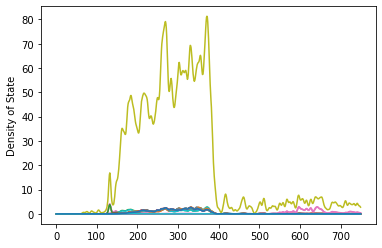

In [3]:
for i in range(1):
#     i = np.random.randint(0, y.shape[0]-1)   
    x_axis = np.arange(0, 750)
    for j in range(x.shape[2]):
        plt.plot(x_axis, x[i, :, j], label="%d"%i)
    plt.ylabel("Density of State")
    plt.show()

## Regularization

In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
scaler = StandardScaler()
x = scaler.fit_transform(x.reshape(-1, x.shape[2])).reshape(x.shape)

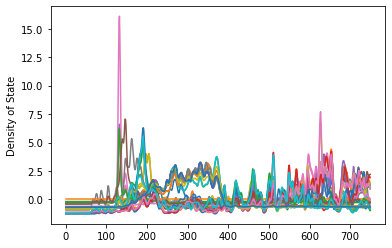

In [5]:
for i in range(1):
#     i = np.random.randint(0, y.shape[0]-1)   
    x_axis = np.arange(0, 750)
    for j in range(x.shape[2]):
        plt.plot(x_axis, x[i, :, j], label="%d"%i)
    plt.ylabel("Density of State")
    plt.show()

## Reshape

In [6]:
x = np.transpose(np.expand_dims(x, axis=1), (0, 1, 3, 2))
print(x.shape)

(960, 1, 41, 750)


# DOS Model Construction

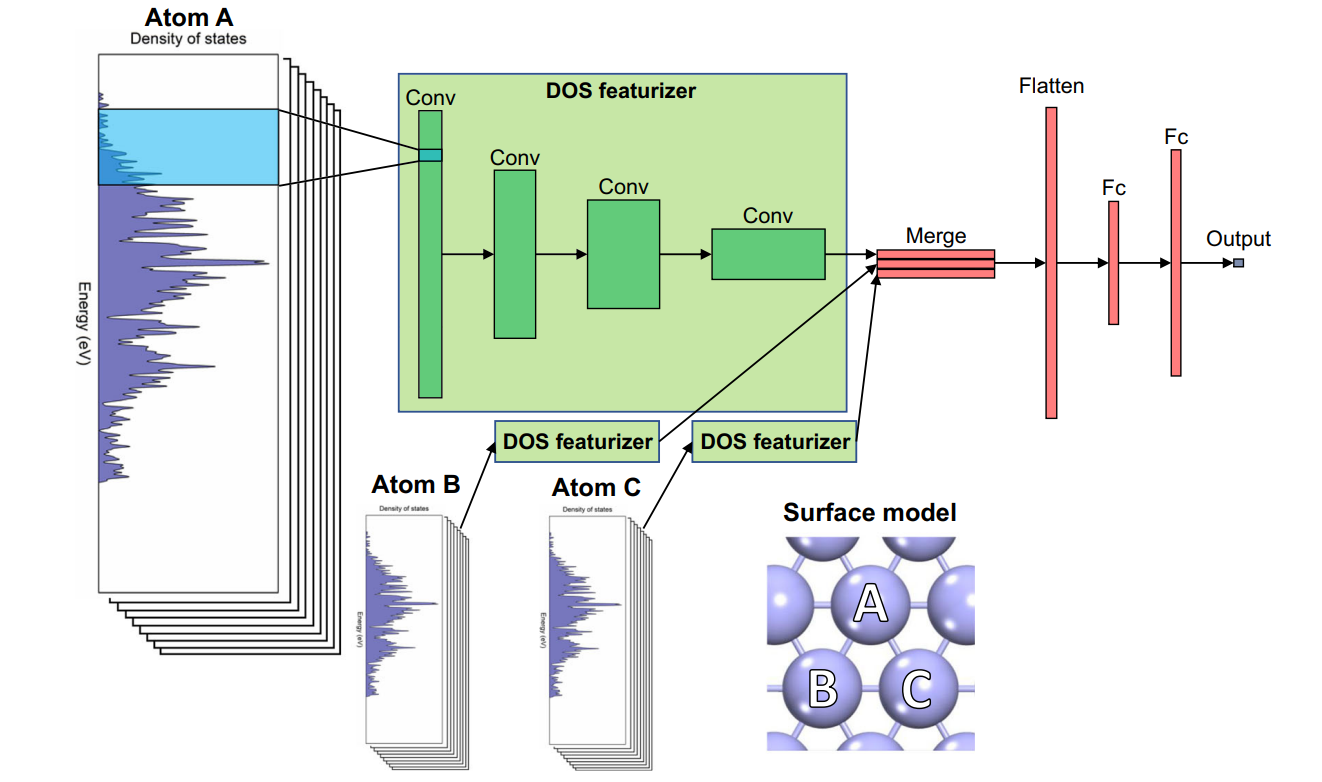

## Model Architecture


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### DeepConvNet
DOS Model with DeepConvNet

In [8]:
class DeepConvNet(nn.Module):
    def __init__(self):
        super(DeepConvNet, self).__init__()
        self.dropout_rate = 0.5
        
        self.dos_featurizer = nn.Sequential(
            
            nn.Conv2d(1, 25, kernel_size=(1, 5)),
            
            nn.Conv2d(25, 25, kernel_size=(3, 1)),
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(self.dropout_rate),
            
            nn.Conv2d(25, 50, kernel_size=(1, 5)),
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(self.dropout_rate),
            
            nn.Conv2d(50, 100, kernel_size=(1, 5)),
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(self.dropout_rate),

            nn.Conv2d(100, 200, kernel_size=(1, 5)),
            nn.BatchNorm2d(200),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(self.dropout_rate),
            
            nn.Flatten(),
#             nn.Linear(8600, 1) # (3, 750)
            nn.Linear(335400, 1) # (41, 750)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(8600*3, 128),
            nn.ReLU(),
            nn.Linear(128, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 1)
        )
        
        
        
    def forward(self, x):
        
        x = self.dos_featurizer(x)
        return x
    
model = DeepConvNet().to(device)
summary(model, [(1, 41, 750)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 25, 41, 746]             150
            Conv2d-2          [-1, 25, 39, 746]           1,900
       BatchNorm2d-3          [-1, 25, 39, 746]              50
              ReLU-4          [-1, 25, 39, 746]               0
         MaxPool2d-5          [-1, 25, 39, 373]               0
           Dropout-6          [-1, 25, 39, 373]               0
            Conv2d-7          [-1, 50, 39, 369]           6,300
       BatchNorm2d-8          [-1, 50, 39, 369]             100
              ReLU-9          [-1, 50, 39, 369]               0
        MaxPool2d-10          [-1, 50, 39, 184]               0
          Dropout-11          [-1, 50, 39, 184]               0
           Conv2d-12         [-1, 100, 39, 180]          25,100
      BatchNorm2d-13         [-1, 100, 39, 180]             200
             ReLU-14         [-1, 100, 

### EEGNet

In [9]:
class DepthwiseConv2d(torch.nn.Conv2d):
    def __init__(self,
                 in_channels,
                 depth_multiplier=1,
                 kernel_size=3,
                 stride=1,
                 padding=0,
                 dilation=1,
                 bias=True,
                 padding_mode='zeros'
                 ):
        out_channels = in_channels * depth_multiplier
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=in_channels,
            bias=bias,
            padding_mode=padding_mode
        )
        
      ## conv with max norm  
#     def forward(self, x):
#     return F.conv2d(x, self.weight.clamp(min=-1.0, max=1.0), self.bias, self.stride,
#                     self.padding, self.dilation, self.groups)

In [10]:
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, groups=in_channels, bias=bias, padding=padding)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, bias=bias)
    
    def forward(self,x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [11]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.C = 3
        self.T = 750
        self.F1 = 16
        self.D = 2
        self.F2 = 32
        self.kernel_length = 64
        self.dropoutRate = 0.2
        
        # block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.F1, kernel_size=(1, 51), padding=(0, 25), stride=(1, 1), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(self.F1)
        self.depthwise1 = DepthwiseConv2d(self.F1, kernel_size=(self.C, 1), depth_multiplier=self.D, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(self.F1*self.D)
        self.relu1 = nn.ReLU()
#         self.lrelu1 = nn.LeakyReLU()
        self.averagePooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(p=self.dropoutRate)
        
        # block 2
        self.separableconv1 = SeparableConv2d(self.F1*self.D, self.F2, kernel_size=(1, 15), padding=(0, 7), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(self.F2)
        self.relu2 = nn.ReLU()
#         self.lrelu2 = nn.LeakyReLU()
        self.averagePooling2 = nn.AvgPool2d(kernel_size=(1,8))
        self.dropout2 = nn.Dropout(p=self.dropoutRate)
        self.flatten1 = nn.Flatten()
        
#         self.dense1 = nn.Linear(736, 1) # [1, 3, 750]
#         self.dense1 = nn.Linear(21344, 1) # [1, 31, 750]
        self.dense1 = nn.Linear(28704, 1) # [1, 41, 750]
        
        
    def forward(self, x):
        
        ## block 1
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.depthwise1(x)
        x = self.batchnorm2(x)
        x = self.relu1(x)
#         x = self.lrelu1(x)
        x = self.averagePooling1(x)
        x = self.dropout1(x)
        
        ## block 2
        x = self.separableconv1(x)
        x = self.batchnorm3(x)
        x = self.relu2(x)
#         x = self.lrelu2(x)
        x = self.averagePooling2(x)
        x = self.dropout2(x)
        x = self.flatten1(x)
        x = self.dense1(x)        
        return x
    
model = EEGNet().to(device)
# model = nn.DataParallel(model)
# print(model)
summary(model, [(1, 41, 750)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 41, 750]             816
       BatchNorm2d-2          [-1, 16, 41, 750]              32
   DepthwiseConv2d-3          [-1, 32, 39, 750]              96
       BatchNorm2d-4          [-1, 32, 39, 750]              64
              ReLU-5          [-1, 32, 39, 750]               0
         AvgPool2d-6          [-1, 32, 39, 187]               0
           Dropout-7          [-1, 32, 39, 187]               0
            Conv2d-8          [-1, 32, 39, 187]             480
            Conv2d-9          [-1, 32, 39, 187]           1,024
  SeparableConv2d-10          [-1, 32, 39, 187]               0
      BatchNorm2d-11          [-1, 32, 39, 187]              64
             ReLU-12          [-1, 32, 39, 187]               0
        AvgPool2d-13           [-1, 32, 39, 23]               0
          Dropout-14           [-1, 32,

## Data Loader

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val, z_train, z_val = train_test_split(x, y, z, test_size=0.2, random_state=8888)

x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).type(torch.float).to(device)
x_val = torch.from_numpy(x_val).float().to(device)
y_val = torch.from_numpy(y_val).type(torch.float).to(device) # data type is long

train = torch.utils.data.TensorDataset(x_train, y_train)
val = torch.utils.data.TensorDataset(x_val, y_val)

batch_size = 128

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

## Training & Validation

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avg_loss, avg_acc, n_correct  = 0, 0, 0
    for batch, (x, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(x)
        y = y.unsqueeze(1)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         optimizer.module.step()
        
        # Record
        avg_loss += loss.item()
        n_correct += torch.sum((torch.abs(pred[:, 0] - y[:, 0]) < torch.abs(0.1* y[:, 0]))).item()
    avg_acc = (n_correct / size * 100.0)  # scalar
    avg_loss /=  size

    return avg_acc, avg_loss


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)
            y = y.unsqueeze(1)
            test_loss += loss_fn(pred, y).item()
            correct += torch.sum((torch.abs(pred[:, 0] - y[:, 0]) < torch.abs(0.1* y[:, 0]))).item()

    correct = (correct / size * 100.0 ) # scalar  test_loss /= len(test_loader)
    test_loss /=  size
    
    return correct, test_loss

In [11]:
epochs = 5000
learning_rate = 1e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
train_acc = []
train_loss = []
val_acc = []
val_loss = []
for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
    tr_acc, tr_loss = train_loop(train_loader, model, loss_fn, optimizer)
    te_acc, te_loss = test_loop(test_loader, model, loss_fn)
    train_acc.append(tr_acc)
    train_loss.append(tr_loss)
    val_acc.append(te_acc)
    val_loss.append(te_loss)
    
    if(t%10==0 or t==epochs-1):            
        print(f"Epoch {t+1}\n-------------------------------")
        print(f"Train Error: \n Accuracy: {(tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(te_acc):>0.1f}%, Avg loss: {te_loss:>8f} \n")


print("Done!")

# print("Saving model weight...")
# torch.save(model, "./DeepConvNet_model.pt")
# print("Save Done!")

Epoch 1
-------------------------------
Train Error: 
 Accuracy: 0.3%, Avg loss: 80.923009 

Test Error: 
 Accuracy: 0.0%, Avg loss: 40.790023 

Epoch 11
-------------------------------
Train Error: 
 Accuracy: 1.8%, Avg loss: 0.084704 

Test Error: 
 Accuracy: 6.2%, Avg loss: 0.055052 

Epoch 21
-------------------------------
Train Error: 
 Accuracy: 6.1%, Avg loss: 0.023938 

Test Error: 
 Accuracy: 5.7%, Avg loss: 0.040798 

Epoch 31
-------------------------------
Train Error: 
 Accuracy: 6.0%, Avg loss: 0.020085 

Test Error: 
 Accuracy: 7.8%, Avg loss: 0.032451 

Epoch 41
-------------------------------
Train Error: 
 Accuracy: 7.2%, Avg loss: 0.016722 

Test Error: 
 Accuracy: 4.2%, Avg loss: 0.031031 

Epoch 51
-------------------------------
Train Error: 
 Accuracy: 7.6%, Avg loss: 0.016218 

Test Error: 
 Accuracy: 4.2%, Avg loss: 0.030208 

Epoch 61
-------------------------------
Train Error: 
 Accuracy: 7.8%, Avg loss: 0.015130 

Test Error: 
 Accuracy: 3.6%, Avg loss: 0.

Epoch 571
-------------------------------
Train Error: 
 Accuracy: 7.7%, Avg loss: 0.024077 

Test Error: 
 Accuracy: 1.6%, Avg loss: 0.140166 

Epoch 581
-------------------------------
Train Error: 
 Accuracy: 6.9%, Avg loss: 0.020212 

Test Error: 
 Accuracy: 3.6%, Avg loss: 0.042077 

Epoch 591
-------------------------------
Train Error: 
 Accuracy: 4.2%, Avg loss: 0.061997 

Test Error: 
 Accuracy: 1.6%, Avg loss: 0.048366 

Epoch 601
-------------------------------
Train Error: 
 Accuracy: 6.8%, Avg loss: 0.021156 

Test Error: 
 Accuracy: 7.3%, Avg loss: 0.029074 

Epoch 611
-------------------------------
Train Error: 
 Accuracy: 8.2%, Avg loss: 0.014139 

Test Error: 
 Accuracy: 10.9%, Avg loss: 0.029411 

Epoch 621
-------------------------------
Train Error: 
 Accuracy: 8.9%, Avg loss: 0.013390 

Test Error: 
 Accuracy: 6.8%, Avg loss: 0.025157 

Epoch 631
-------------------------------
Train Error: 
 Accuracy: 5.1%, Avg loss: 0.029115 

Test Error: 
 Accuracy: 4.2%, Avg l

Epoch 1141
-------------------------------
Train Error: 
 Accuracy: 10.7%, Avg loss: 0.008321 

Test Error: 
 Accuracy: 10.9%, Avg loss: 0.018859 

Epoch 1151
-------------------------------
Train Error: 
 Accuracy: 7.3%, Avg loss: 0.012925 

Test Error: 
 Accuracy: 5.2%, Avg loss: 0.022073 

Epoch 1161
-------------------------------
Train Error: 
 Accuracy: 7.4%, Avg loss: 0.020117 

Test Error: 
 Accuracy: 12.0%, Avg loss: 0.018334 

Epoch 1171
-------------------------------
Train Error: 
 Accuracy: 4.9%, Avg loss: 0.022903 

Test Error: 
 Accuracy: 7.3%, Avg loss: 0.025466 

Epoch 1181
-------------------------------
Train Error: 
 Accuracy: 11.3%, Avg loss: 0.008056 

Test Error: 
 Accuracy: 6.2%, Avg loss: 0.025548 

Epoch 1191
-------------------------------
Train Error: 
 Accuracy: 12.4%, Avg loss: 0.006059 

Test Error: 
 Accuracy: 9.9%, Avg loss: 0.020581 

Epoch 1201
-------------------------------
Train Error: 
 Accuracy: 11.8%, Avg loss: 0.008151 

Test Error: 
 Accuracy:

Epoch 1701
-------------------------------
Train Error: 
 Accuracy: 17.7%, Avg loss: 0.003051 

Test Error: 
 Accuracy: 9.4%, Avg loss: 0.014705 

Epoch 1711
-------------------------------
Train Error: 
 Accuracy: 20.1%, Avg loss: 0.002243 

Test Error: 
 Accuracy: 8.9%, Avg loss: 0.015757 

Epoch 1721
-------------------------------
Train Error: 
 Accuracy: 19.1%, Avg loss: 0.002084 

Test Error: 
 Accuracy: 14.6%, Avg loss: 0.016944 

Epoch 1731
-------------------------------
Train Error: 
 Accuracy: 20.6%, Avg loss: 0.002362 

Test Error: 
 Accuracy: 12.0%, Avg loss: 0.013620 

Epoch 1741
-------------------------------
Train Error: 
 Accuracy: 18.5%, Avg loss: 0.002472 

Test Error: 
 Accuracy: 12.0%, Avg loss: 0.013581 

Epoch 1751
-------------------------------
Train Error: 
 Accuracy: 18.1%, Avg loss: 0.002508 

Test Error: 
 Accuracy: 13.5%, Avg loss: 0.014587 

Epoch 1761
-------------------------------
Train Error: 
 Accuracy: 19.8%, Avg loss: 0.002257 

Test Error: 
 Accu

Epoch 2261
-------------------------------
Train Error: 
 Accuracy: 26.2%, Avg loss: 0.001114 

Test Error: 
 Accuracy: 14.6%, Avg loss: 0.015878 

Epoch 2271
-------------------------------
Train Error: 
 Accuracy: 24.5%, Avg loss: 0.001356 

Test Error: 
 Accuracy: 9.9%, Avg loss: 0.013809 

Epoch 2281
-------------------------------
Train Error: 
 Accuracy: 25.0%, Avg loss: 0.001282 

Test Error: 
 Accuracy: 13.5%, Avg loss: 0.013479 

Epoch 2291
-------------------------------
Train Error: 
 Accuracy: 29.8%, Avg loss: 0.001048 

Test Error: 
 Accuracy: 13.5%, Avg loss: 0.012679 

Epoch 2301
-------------------------------
Train Error: 
 Accuracy: 25.4%, Avg loss: 0.001211 

Test Error: 
 Accuracy: 12.5%, Avg loss: 0.012814 

Epoch 2311
-------------------------------
Train Error: 
 Accuracy: 26.0%, Avg loss: 0.001200 

Test Error: 
 Accuracy: 8.3%, Avg loss: 0.015485 

Epoch 2321
-------------------------------
Train Error: 
 Accuracy: 29.3%, Avg loss: 0.001076 

Test Error: 
 Accu

Epoch 2821
-------------------------------
Train Error: 
 Accuracy: 28.1%, Avg loss: 0.000959 

Test Error: 
 Accuracy: 13.0%, Avg loss: 0.013627 

Epoch 2831
-------------------------------
Train Error: 
 Accuracy: 28.9%, Avg loss: 0.000817 

Test Error: 
 Accuracy: 11.5%, Avg loss: 0.012056 

Epoch 2841
-------------------------------
Train Error: 
 Accuracy: 29.2%, Avg loss: 0.000843 

Test Error: 
 Accuracy: 11.5%, Avg loss: 0.014104 

Epoch 2851
-------------------------------
Train Error: 
 Accuracy: 28.1%, Avg loss: 0.001004 

Test Error: 
 Accuracy: 12.0%, Avg loss: 0.014274 

Epoch 2861
-------------------------------
Train Error: 
 Accuracy: 30.6%, Avg loss: 0.000808 

Test Error: 
 Accuracy: 16.7%, Avg loss: 0.015723 

Epoch 2871
-------------------------------
Train Error: 
 Accuracy: 30.5%, Avg loss: 0.000856 

Test Error: 
 Accuracy: 13.0%, Avg loss: 0.014992 

Epoch 2881
-------------------------------
Train Error: 
 Accuracy: 31.2%, Avg loss: 0.000772 

Test Error: 
 Ac

Epoch 3381
-------------------------------
Train Error: 
 Accuracy: 32.8%, Avg loss: 0.000639 

Test Error: 
 Accuracy: 9.9%, Avg loss: 0.017103 

Epoch 3391
-------------------------------
Train Error: 
 Accuracy: 30.9%, Avg loss: 0.000820 

Test Error: 
 Accuracy: 14.1%, Avg loss: 0.013359 

Epoch 3401
-------------------------------
Train Error: 
 Accuracy: 27.5%, Avg loss: 0.000887 

Test Error: 
 Accuracy: 13.0%, Avg loss: 0.013479 

Epoch 3411
-------------------------------
Train Error: 
 Accuracy: 32.8%, Avg loss: 0.000672 

Test Error: 
 Accuracy: 8.3%, Avg loss: 0.013741 

Epoch 3421
-------------------------------
Train Error: 
 Accuracy: 25.1%, Avg loss: 0.001051 

Test Error: 
 Accuracy: 12.5%, Avg loss: 0.013205 

Epoch 3431
-------------------------------
Train Error: 
 Accuracy: 31.5%, Avg loss: 0.000780 

Test Error: 
 Accuracy: 15.1%, Avg loss: 0.015114 

Epoch 3441
-------------------------------
Train Error: 
 Accuracy: 27.9%, Avg loss: 0.000858 

Test Error: 
 Accu

Epoch 3941
-------------------------------
Train Error: 
 Accuracy: 34.4%, Avg loss: 0.000633 

Test Error: 
 Accuracy: 12.0%, Avg loss: 0.015841 

Epoch 3951
-------------------------------
Train Error: 
 Accuracy: 36.8%, Avg loss: 0.000564 

Test Error: 
 Accuracy: 10.9%, Avg loss: 0.016559 

Epoch 3961
-------------------------------
Train Error: 
 Accuracy: 34.4%, Avg loss: 0.000688 

Test Error: 
 Accuracy: 15.6%, Avg loss: 0.015211 

Epoch 3971
-------------------------------
Train Error: 
 Accuracy: 34.6%, Avg loss: 0.000615 

Test Error: 
 Accuracy: 14.1%, Avg loss: 0.015947 

Epoch 3981
-------------------------------
Train Error: 
 Accuracy: 33.5%, Avg loss: 0.000610 

Test Error: 
 Accuracy: 15.1%, Avg loss: 0.015878 

Epoch 3991
-------------------------------
Train Error: 
 Accuracy: 36.5%, Avg loss: 0.000534 

Test Error: 
 Accuracy: 9.9%, Avg loss: 0.016498 

Epoch 4001
-------------------------------
Train Error: 
 Accuracy: 33.2%, Avg loss: 0.000725 

Test Error: 
 Acc

Epoch 4501
-------------------------------
Train Error: 
 Accuracy: 32.4%, Avg loss: 0.000746 

Test Error: 
 Accuracy: 12.0%, Avg loss: 0.016875 

Epoch 4511
-------------------------------
Train Error: 
 Accuracy: 33.2%, Avg loss: 0.000658 

Test Error: 
 Accuracy: 14.1%, Avg loss: 0.016716 

Epoch 4521
-------------------------------
Train Error: 
 Accuracy: 32.6%, Avg loss: 0.000730 

Test Error: 
 Accuracy: 10.9%, Avg loss: 0.017825 

Epoch 4531
-------------------------------
Train Error: 
 Accuracy: 29.2%, Avg loss: 0.000964 

Test Error: 
 Accuracy: 13.0%, Avg loss: 0.014497 

Epoch 4541
-------------------------------
Train Error: 
 Accuracy: 30.1%, Avg loss: 0.000674 

Test Error: 
 Accuracy: 14.6%, Avg loss: 0.018350 

Epoch 4551
-------------------------------
Train Error: 
 Accuracy: 35.3%, Avg loss: 0.000669 

Test Error: 
 Accuracy: 9.9%, Avg loss: 0.018227 

Epoch 4561
-------------------------------
Train Error: 
 Accuracy: 36.8%, Avg loss: 0.000624 

Test Error: 
 Acc

In [12]:
print("Saving model weight...")
torch.save(model, "./DeepCovNet_model.pt")
print("Save Done!")

print("Saving loss and acc...")
np.savez("DeepCovNet_para.npz", train_loss=np.array(train_loss), val_loss=np.array(val_loss), train_acc=np.array(train_acc), val_acc=np.array(val_acc))

Saving model weight...
Save Done!
Saving loss and acc...


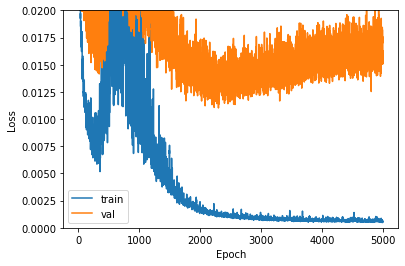

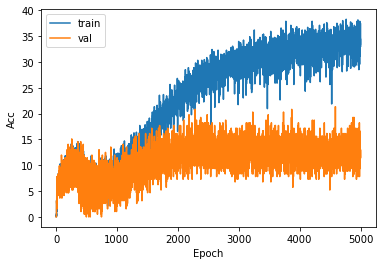

In [18]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.ylim(0, 0.02)
x = np.arange(1, len(train_loss)+1)
plt.plot(x, train_loss, label="train")
plt.plot(x, val_loss, label='val')
plt.legend()
plt.show()

plt.figure()
plt.ylabel("Acc")
plt.xlabel("Epoch")
# plt.ylim(0, 0.01)
x = np.arange(1, len(train_loss)+1)
plt.plot(x, train_acc, label="train")
plt.plot(x, val_acc, label='val')
plt.legend()
plt.show()

## Correlation of Ground Truth and Prediction

In [14]:
test_loss, correct = 0, 0
with torch.no_grad():
    pred = model(x_val)
    target = y_val.unsqueeze(1)
    test_loss += loss_fn(pred, target).item()
    correct = torch.sum((torch.abs(pred[:, 0] - target[:, 0]) < torch.abs(0.1* target[:, 0]))).item()

correct /= len(x_val)
test_loss /=  len(x_val)
print("Loss:", test_loss)
print("Accuracy:", correct)

Loss: 0.008471472809712092
Accuracy: 0.13020833333333334


Corr: 0.806429
Loss: 0.008471


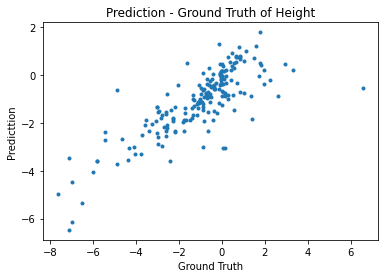

In [15]:
from scipy.stats import pearsonr

# print(y_val.cpu().shape)
# print(pred.cpu().numpy()[:,0])
plt.title( "Prediction - Ground Truth of Height")
plt.xlabel( "Ground Truth")
plt.ylabel( "Predicttion")
plt.plot( y_val.cpu().numpy(), pred.cpu().numpy()[:,0], linestyle = 'None', marker='.')# plot( x, y)
corr, _ = pearsonr(y_val.cpu().numpy(), pred.cpu().numpy()[:,0])
slope = "Corr: " + "%.6f"%corr + "\nLoss: " + "%.6f"%test_loss
print(slope)
# plt.text( 0, , slope)
plt.show()

In [16]:
val_1 = pred.cpu().numpy()[:,0]
val_2 = y_val.cpu().numpy()
for i in range(len(val_1)):
#     print(val_1[i], '\t', val_2[i], '\t', np.abs(val_1[i]-val_2[i]))
    if (np.abs(val_1[i]-val_2[i])) > 5:
        print(i, val_1[i], val_2[i])

135 -0.54042375 6.56


# Load Weight & See the result

In [12]:
model = torch.load('DeepCovNet_model.pt', map_location=device)
test_loss = 0
correct = 0
with torch.no_grad():
    pred = model(x_val)
    target = y_val.unsqueeze(1)
    test_loss += loss_fn(pred, target).item()
    correct = torch.sum((torch.abs(pred[:, 0] - target[:, 0]) < torch.abs(0.1* target[:, 0]))).item()
correct /= len(x_val)
test_loss /=  len(x_val)
print("Loss:", test_loss)
print("Accuracy:", correct)

Loss: 0.008320584893226624
Accuracy: 0.109375


Corr: 0.810735
Loss: 0.008321


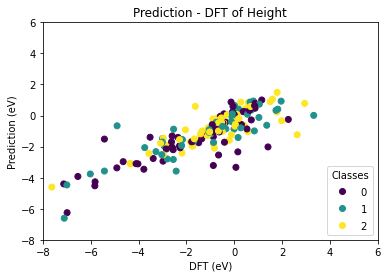

In [15]:
from scipy.stats import pearsonr
val = y_val.cpu().numpy()
predict = pred.cpu().numpy()[:,0]

# label
label = []
metal_dict = {'Ag':0, "Au":1, 'Cu':2}
metal_list = ['Ag', 'Au', 'Cu']
# sub_metal_dict = {'Ti': 0, 'V': 1, 'Cr': 2, 'Mn': 3, 'Fe': 4, 'Co': 5, 'Ni': 6, 'Mo': 7, 'Zr': 8, 'Nb': 9, 'Ru': 10, 'Rh': 11, 'Pd': 12, 'Hf': 13, 'Ta': 14, 'W': 15, 'Re': 16, 'Os': 17, 'Ir': 18, 'Pt': 19}
sub_metal_dict = {"Ti":0, "V":0, "Cr":0, "Mn":0, "Fe":0, "Co":0, "Ni":0, "Mo":1, "Zr":1, "Nb":1, "Ru":1, "Rh":1, "Pd":1, "Hf":2, "Ta":2, "W":2, "Re":2, "Os":2, "Ir":2, "Pt":2}
sub_metal_list = ['Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Mo', 'Zr', 'Nb', 'Ru', 'Rh', 'Pd', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt']
condition = "sub_metal"

for l in z_val:
    if condition=="metal":
        label.append(metal_dict[l[0]])
    elif condition=="sub_metal":
        label.append(sub_metal_dict[l[1]])
    elif condition=="adsorb":
        if l[2] in ["H2", "O2", "N2", "CO2"]:
            label.append(0)
        elif l[2] in ["H", "O", "N", "CO"]:
            label.append(1)
        else:
            label.append(2)
        
fig, ax = plt.subplots()
plt.title( "Prediction - DFT of Height")
plt.xlabel( "DFT (eV)")
plt.ylabel( "Prediction (eV)")
plt.ylim(-8, 6)
plt.xlim(-8, 6)
scatter = ax.scatter( val, predict, c=label)
legend1 = ax.legend(*scatter.legend_elements(num=2),
                    loc="lower right", 
                    title="Classes",
#                     bbox_to_anchor=(1.2, -0.5)
                   )
# ax.add_artist(legend1)
corr, _ = pearsonr( val, predict)
slope = "Corr: " + "%.6f"%corr + "\nLoss: " + "%.6f"%test_loss
print(slope)
plt.show()